# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# Applying Multinomial Naive Bayes

##  Applying Naive Bayes on BOW

In [2]:
# Working with 50K points for brute force

# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Cleaning : Deduplication

In [3]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries 
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


## Observation:
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [10]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ..."
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...


## Preprocessing

## Prerpocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags Remove any punctuations or limited set of special characters like , or . or # etc. Check if the word is made up of english letters and is not alpha-numeric Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) Convert the word to lowercase Remove Stopwords Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews

In [11]:
# Importing necessary libraries

from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)# To remove urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()# To remove numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) # To remove special characters
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)# To convert to lower case letters
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:44<00:00, 1961.60it/s]


In [14]:
# Adding a new column "Review_Text" to the "final" dataframe with the Text "preprocessed_reviews"

final["Review_Text"]=preprocessed_reviews

In [15]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...


## Sorting the data in descenindg order based on Time Column

In [16]:
final=final.sort_values(by='Time',axis=0,ascending=False)

In [18]:
final.head(50)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
5259,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...,purchased product local store ny kids love qui...
1005,1089,B004FD13RW,A1BPLP0BKERV,Paul,0,0,1,1351209600,It is awesome.,"My partner is very happy with the tea, and is ...",partner happy tea feeling much better since st...
63160,68621,B005IOXBY0,A1ORVAUR5C5N8X,amondigirl,0,0,1,1351209600,WOW.....,This chocolate is amazing..I love the taste an...,chocolate amazing love taste smell chocolate f...
9513,10404,B005HI55CS,A36ERNIM0TKG3T,Donald E. Bolton,0,0,1,1351209600,Hidden Springs Maple syrup,This is one of the very finest maple syrups I ...,one finest maple syrups ordered enjoyed bought...
86066,93711,B001NZPFB0,A3318V6FJ2KIII,T. Dennis,0,0,1,1351209600,My dog enjoys it and it helps her hips.,My dog was diagnosed with hip dysplasia as a 6...,dog diagnosed hip dysplasia old puppy vet said...
30235,32932,B001P05K8Q,A3L0B5NBTQ7ZHO,Julie,0,0,1,1351209600,Great results but they stink,We originally purchased these chews from our v...,originally purchased chews veterinarian decide...
96778,105165,B005EF0HZ4,A2A5Z7LC91EFVA,Gretchen Casey,0,0,1,1351209600,Gluten Free Kid,We LOVE Lucy's cookies! The Maple Bliss are w...,love lucy cookies maple bliss wonderful bad ha...
96779,105166,B005EF0HZ4,A1JXSMYVHFPWM1,marsha m beers,0,0,0,1351209600,Disappointed,I have not been able to find the Maple flavor ...,not able find maple flavor cookies area anywhe...
39050,42397,B0014DXT5A,AZUCLRMHEBUG0,"T. HANLEY ""reader""",0,0,1,1351209600,ZipFizz liquid energy shot,Have used this for years. Gives long lasting ...,used years gives long lasting energy boost no ...
5472,5924,B00523NRVO,A2JDXKFZ0PFHKU,James W. Shondel,0,0,1,1351209600,The perfect pop!,"These lollipops are are well done, look exactl...",lollipops well done look exactly like picture ...


In [19]:
# Dropping unnecessary columns and keeping only Review_Text and Score Columns

final_df=final[['Review_Text','Score']]

In [20]:
final_df.shape

(87773, 2)

In [21]:
final_df.head()

,Review_Text,Score
5259,purchased product local store ny kids love qui...,1
1005,partner happy tea feeling much better since st...,1
63160,chocolate amazing love taste smell chocolate f...,1
9513,one finest maple syrups ordered enjoyed bought...,1
86066,dog diagnosed hip dysplasia old puppy vet said...,1


In [22]:
#Splitting the data into Features and Labels

X=final_df['Review_Text'].values
y=final_df['Score'].values

In [23]:
# Splitting the data into Training and Testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=3,shuffle=False) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30,random_state=3,shuffle=False) # this is random splitting

In [24]:
# Shape of the Training and Test data

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)



(43008,) (43008,)
(18433,) (18433,)
(26332,) (26332,)


In [25]:
# Converting to BOW

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)


print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(43008, 38523) (43008,)
(18433, 38523) (18433,)
(26332, 38523) (26332,)


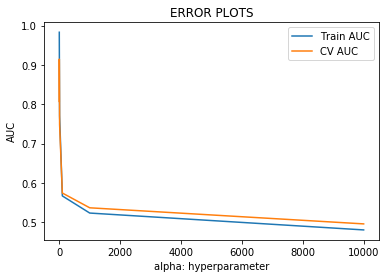

In [26]:
# Hyper parameter tuning to find best alpha
# Simple Cross validation

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]
for i in alpha:
    NB =MultinomialNB(alpha=i)
    NB.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  NB.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  NB.predict_proba(X_cv_bow)[:,1]
    y_test_pred =  NB.predict_proba(X_test_bow)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can not find best alpha since we can not see '10**-5','10**-4'..etc values in the plot.
To sove that,we use semilogx as below.

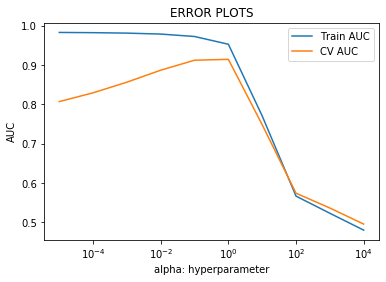

In [32]:
# Hyper parameter tuning to find best alpha
# Simple Cross validation

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]
for i in alpha:
    NB =MultinomialNB(alpha=i)
    NB.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  NB.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  NB.predict_proba(X_cv_bow)[:,1]
    y_test_pred =  NB.predict_proba(X_test_bow)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.semilogx(alpha, train_auc,label='Train AUC')
plt.semilogx(alpha, cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the plot,we can see that the best alpha value is 10 power -1 where CV AUC and Train ACU are high and the gap is less

## Building MultinomialNB with best alpha value:10 ** -1

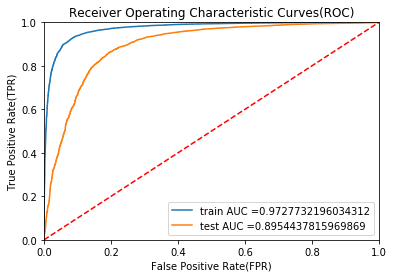

In [33]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
MNB=MultinomialNB(alpha=10**-1,class_prior=[0.5,0.5])
MNB.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_bow = roc_curve(y_train, MNB.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds_te_bow = roc_curve(y_test, MNB.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting confusion matrix using seaborn

In [34]:
# we are writing our own function to predict, with defined thresould
# we will pick a threshold that will give the least fpr

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print()
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [35]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_bow, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.8495878427160344 for threshold 0.521

Train confusion matrix:

[[    0  7516]
 [    0 35492]]

Test confusion matrix:

[[    0  3470]
 [    0 22862]]


In [36]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

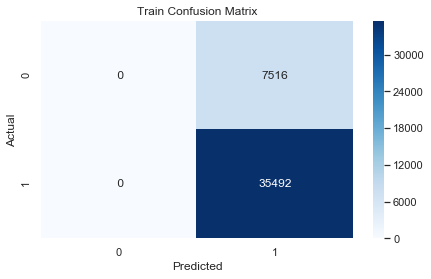

In [37]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

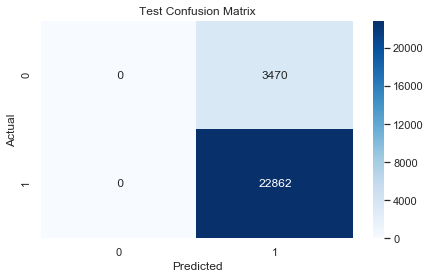

In [38]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Top 10 important features of positive class

In [39]:
Pos_Class_features=MNB.feature_log_prob_[1,:]

In [40]:
Pos_Class_features

array([-11.92431169, -13.00118399, -14.03727592, ..., -14.03727592,
       -14.03727592, -14.03727592])

In [41]:
Pos_Class_features=Pos_Class_features.argsort()

In [42]:
Pos_Class_features

array([33954,  9451, 26895, ..., 14424, 19285, 22728], dtype=int64)

In [43]:
# Writing the above lines in the same cell
Pos_Class_features=MNB.feature_log_prob_[1,:].argsort()
Pos_Class_features

array([33954,  9451, 26895, ..., 14424, 19285, 22728], dtype=int64)

In [44]:
# Finding top 10 features of Positive Class
Pos_Class_features=Pos_Class_features[-10:]
Pos_Class_features

array([19741, 12690, 37945, 33663, 23392,  6493, 14724, 14424, 19285,
       22728], dtype=int64)

In [45]:
# printing the top 10 positive feature names

print(np.take(vectorizer.get_feature_names(),Pos_Class_features))

['love' 'flavor' 'would' 'taste' 'one' 'coffee' 'great' 'good' 'like'
 'not']


In [46]:
features=np.take(vectorizer.get_feature_names(),Pos_Class_features)

In [47]:
type(features)

numpy.ndarray

In [48]:
features

array(['love', 'flavor', 'would', 'taste', 'one', 'coffee', 'great',
       'good', 'like', 'not'], dtype='<U79')

In [49]:
# Creating a dataframe for the top 10 featues and their feature_log_probabilities

Postive_features=pd.DataFrame(MNB.feature_log_prob_[1,:],columns=['feature_log_probabilities'])
Top_10_Positive_features=Postive_features.sort_values(by='feature_log_probabilities',ascending=False)

In [50]:
Top_10_Positive_features=Top_10_Positive_features.head(10)

In [51]:
Top_10_Positive_features['feature_names']=features

In [52]:
Top_10_Positive_features

,feature_log_probabilities,feature_names
22728,-3.710867,love
19285,-4.512716,flavor
14424,-4.654963,would
14724,-4.729471,taste
6493,-4.853084,one
23392,-4.877550,coffee
33663,-4.953932,great
37945,-5.022276,good
12690,-5.041243,like
19741,-5.052457,not


### Top 10 important features of negative class

In [53]:
# Writing the above lines in the same cell
Neg_Class_features=MNB.feature_log_prob_[0,:].argsort()
Neg_Class_features

array([19261, 21635, 21632, ..., 26360, 19285, 22728], dtype=int64)

In [54]:
# Finding top 10 features of Negative Class
Neg_Class_features=Pos_Class_features[-10:]
Neg_Class_features

array([19741, 12690, 37945, 33663, 23392,  6493, 14724, 14424, 19285,
       22728], dtype=int64)

In [55]:
# printing the top 10 Negative feature names

print(np.take(vectorizer.get_feature_names(),Neg_Class_features))

['love' 'flavor' 'would' 'taste' 'one' 'coffee' 'great' 'good' 'like'
 'not']


In [56]:
Neg_features=np.take(vectorizer.get_feature_names(),Neg_Class_features)

In [57]:
# Creating a dataframe for the top 10 featues and their feature_log_probabilities

Negative_features=pd.DataFrame(MNB.feature_log_prob_[0,:],columns=['feature_log_probabilities'])
Top_10_Negative_features=Negative_features.sort_values(by='feature_log_probabilities',ascending=False)

In [58]:
Top_10_Negative_features=Top_10_Negative_features.head(10)

In [59]:
Top_10_Negative_features['Negative_features']=Neg_features

In [60]:
Top_10_Negative_features

,feature_log_probabilities,Negative_features
22728,-3.259090,love
19285,-4.380785,flavor
26360,-4.663087,would
37945,-4.665296,taste
33663,-4.691212,one
23392,-4.925348,coffee
6493,-5.072958,great
22578,-5.152483,good
14424,-5.155057,like
12690,-5.198242,not


##  Applying Naive Bayes on TFIDF

In [61]:
tf_idf_vect = TfidfVectorizer(norm='l2',ngram_range=(1,2),min_df=5)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted Tfidf vectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(43008, 57213) (43008,)
(18433, 57213) (18433,)
(26332, 57213) (26332,)


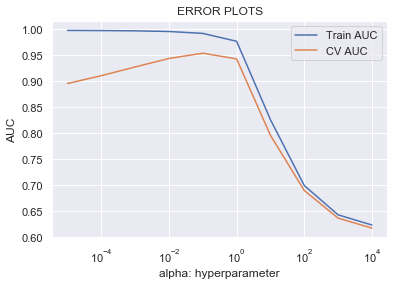

In [63]:
# Hyper parameter tuning to find best alpha
# Simple Cross validation

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]
for i in alpha:
    NB =MultinomialNB(alpha=i)
    NB.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  NB.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  NB.predict_proba(X_cv_tfidf)[:,1]
    y_test_pred =  NB.predict_proba(X_test_tfidf)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.semilogx(alpha, train_auc,label='Train AUC')
plt.semilogx(alpha, cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best alpha value is at 10^-1


## Building the model with best alpha

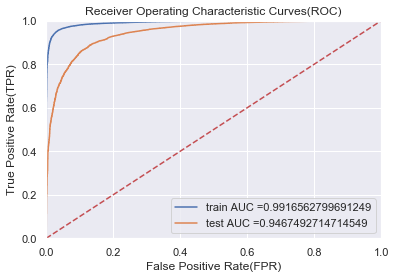

In [64]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
MNB=MultinomialNB(alpha=10**-1,class_prior=[0.5,0.5])
MNB.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_tfidf = roc_curve(y_train, MNB.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds_te_tfidf = roc_curve(y_test, MNB.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting confusion matrix using seaborn

In [65]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_tfidf, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.9223652188978325 for threshold 0.432

Train confusion matrix:

[[    0  7516]
 [    0 35492]]

Test confusion matrix:

[[    0  3470]
 [    0 22862]]


In [66]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

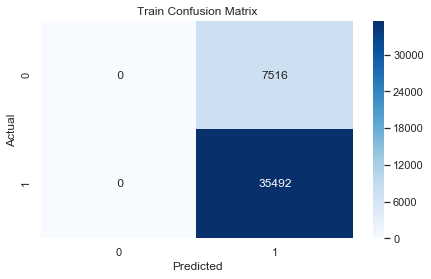

In [67]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

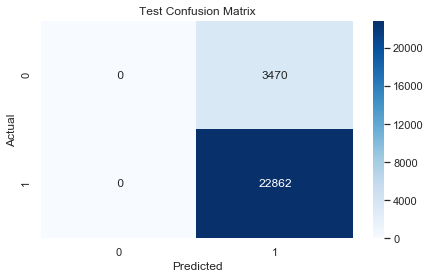

In [68]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Top 10 important features of positive class

In [69]:
Pos_Class_features=MNB.feature_log_prob_[1,:].argsort()
Pos_Class_features

array([50492, 26447, 32133, ...,  8987, 22185, 33506], dtype=int64)

In [70]:
# Finding top 10 features of Positive Class
Pos_Class_features=Pos_Class_features[-10:]
Pos_Class_features

array([17892, 49252, 35266, 39516, 28842, 27094, 21327,  8987, 22185,
       33506], dtype=int64)

In [71]:
# printing the top 10 positive feature names

print(np.take(tf_idf_vect.get_feature_names(),Pos_Class_features))

['flavor' 'taste' 'one' 'product' 'love' 'like' 'good' 'coffee' 'great'
 'not']


In [72]:
features=np.take(tf_idf_vect.get_feature_names(),Pos_Class_features)

In [73]:
# Creating a dataframe for the top 10 featues and their feature_log_probabilities

Postive_features=pd.DataFrame(MNB.feature_log_prob_[1,:],columns=['feature_log_probabilities'])
Top_10_Positive_features=Postive_features.sort_values(by='feature_log_probabilities',ascending=False)

In [74]:
Top_10_Positive_features=Top_10_Positive_features.head(10)

In [75]:
Top_10_Positive_features['feature_names']=features

In [76]:
Top_10_Positive_features

,feature_log_probabilities,feature_names
33506,-5.408740,flavor
22185,-5.736752,taste
8987,-5.793799,one
21327,-5.810232,product
27094,-5.863073,love
28842,-5.976745,like
39516,-6.083205,good
35266,-6.096458,coffee
49252,-6.102014,great
17892,-6.119293,not


### Top 10 important features of negative class

In [77]:
Neg_Class_features=MNB.feature_log_prob_[0,:].argsort()
Neg_Class_features

array([28606, 25772, 25771, ..., 39516, 27094, 33506], dtype=int64)

In [78]:
# Finding top 10 features of Negative Class
Neg_Class_features=Pos_Class_features[-10:]
Neg_Class_features

array([17892, 49252, 35266, 39516, 28842, 27094, 21327,  8987, 22185,
       33506], dtype=int64)

In [79]:
# printing the top 10 Negative feature names

print(np.take(tf_idf_vect.get_feature_names(),Neg_Class_features))

['flavor' 'taste' 'one' 'product' 'love' 'like' 'good' 'coffee' 'great'
 'not']


In [80]:
# Creating a dataframe for the top 10 featues and their feature_log_probabilities

Negative_features=pd.DataFrame(MNB.feature_log_prob_[0,:],columns=['feature_log_probabilities'])
Top_10_Negative_features=Negative_features.sort_values(by='feature_log_probabilities',ascending=False)

In [81]:
Neg_features=np.take(tf_idf_vect.get_feature_names(),Neg_Class_features)

In [82]:
Top_10_Negative_features=Top_10_Negative_features.head(10)

In [83]:
Top_10_Negative_features['Negative_features']=Neg_features

In [84]:
Top_10_Negative_features

,feature_log_probabilities,Negative_features
33506,-4.897908,flavor
27094,-5.718180,taste
39516,-5.815648,one
49252,-5.860148,product
56487,-5.888797,love
8987,-6.094955,like
35266,-6.190675,good
33068,-6.281613,coffee
17892,-6.314565,great
18672,-6.421858,not


# Conclusions

In [85]:
from prettytable import PrettyTable

In [86]:
x=PrettyTable()

In [87]:
x.field_names=['Vectorizer','Hyper Parameter_alpha','AUC']

In [88]:
x.add_row(['BOW',10**-1,0.89])
x.add_row(['TFIDF',10**-1,0.94])

In [89]:
print(x)

+------------+-----------------------+------+
| Vectorizer | Hyper Parameter_alpha | AUC  |
+------------+-----------------------+------+
|    BOW     |          0.1          | 0.89 |
|   TFIDF    |          0.1          | 0.94 |
+------------+-----------------------+------+
